In [ ]:
%matplotlib inline

In [ ]:
import pandas as pd
import numpy as np

# Let's generate a big non-linear data set

In [ ]:
N = 100000 

beta_x = np.random.normal(2, size=N)# 2
beta_z = 5.

z = np.random.normal(50, 10, size=N)
x = np.random.binomial(1, p=1/(1 + np.exp(-(z - z.mean())/z.std())))

y = np.random.poisson(beta_x * x + beta_z * (3 + np.sin(phi_z/0.5)))

df = pd.DataFrame({'z': z, 'x': x, 'y': y})

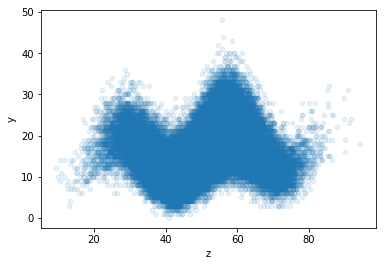

In [ ]:
df.plot(y='y', x='z', kind='scatter', alpha=0.1)

# Look at the naive estimator

This is a pretty tricky relationship! Now, let's check the naive estimator. The true effect (read it above!) is $\delta = 2$.

In [ ]:
df.groupby('x').mean()['y'][1] - df.groupby('x').mean()['y'][0]

3.4203255962205805

Around 70% error -- that's pretty biased! This problem would be hard one to solve using linear regression. Matching or stratification would work here, but let's try our new tool: MSE minimizing ML models! Let's see if the universal function approximator can do the trick.

# Create a propensity model

In [ ]:
from statsmodels.discrete.discrete_model import Logit


df['intercept'] = 1
model = Logit(endog=df['x'], 
              exog=df[['z', 'intercept']])
result = model.fit()
result.summary()


Optimization terminated successfully.
         Current function value: 0.598693
         Iterations 5


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                      x   No. Observations:               100000
Model:                          Logit   Df Residuals:                    99998
Method:                           MLE   Df Model:                            1
Date:                Tue, 16 Feb 2021   Pseudo R-squ.:                  0.1363
Time:                        20:53:04   Log-Likelihood:                -59869.
converged:                       True   LL-Null:                       -69314.
Covariance Type:            nonrobust   LLR p-value:                     0.000
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
z              0.1008      0.001    120.466      0.000       0.099       0.102
intercept     -5.0438      0.042   -118.916      0.000      -5.127      -4.961
==============================================================================
"""

In [ ]:
df['propensity_score'] = df['x'] * result.predict() + \
                         (1 - df['x']) * (1 - result.predict())

In [ ]:
from keras.layers import Dense, Input
from keras.models import Model


x_in = Input(shape=(1,))
h1 = Dense(128, activation='tanh')(x_in)
h2 = Dense(128, activation='tanh')(h1)
h3 = Dense(128, activation='tanh')(h2)
h4 = Dense(128, activation='tanh')(h3)
y = Dense(1, activation='linear')(h4)

model = Model(inputs=[x_in], outputs=[y])
model.compile('adam', loss='mse', metrics=['mse'])

In [ ]:
# I've got a GPU, so this doesn't take too long to run. You 
# might want to reduce batch size and number of epochs on a CPU

model.fit(df[['x']], df[['y']], 
          epochs=100, batch_size=1024, 
          sample_weight=1. / df['propensity_score'])

Epoch 1/100
98/98 [==============================] - 1s 3ms/step - loss: 243.1775 - mse: 119.2919
Epoch 2/100
98/98 [==============================] - 0s 3ms/step - loss: 58.8299 - mse: 30.0343
Epoch 3/100
98/98 [==============================] - 0s 3ms/step - loss: 57.6586 - mse: 28.8922
Epoch 4/100
98/98 [==============================] - 0s 3ms/step - loss: 58.7659 - mse: 29.2021
Epoch 5/100
98/98 [==============================] - 0s 3ms/step - loss: 58.4326 - mse: 29.1194
Epoch 6/100
98/98 [==============================] - 0s 3ms/step - loss: 58.1209 - mse: 29.1385
Epoch 7/100
98/98 [==============================] - 0s 3ms/step - loss: 58.1300 - mse: 28.9537
Epoch 8/100
98/98 [==============================] - 0s 3ms/step - loss: 58.0250 - mse: 29.0779
Epoch 9/100
98/98 [==============================] - 0s 3ms/step - loss: 58.4418 - mse: 29.1832
Epoch 10/100
98/98 [==============================] - 0s 3ms/step - loss: 57.8947 - mse: 28.9211
Epoch 11/100
98/98 [=================

98/98 [==============================] - 0s 3ms/step - loss: 57.8056 - mse: 28.9685
Epoch 86/100
98/98 [==============================] - 0s 3ms/step - loss: 58.1381 - mse: 28.9634
Epoch 87/100
98/98 [==============================] - 0s 3ms/step - loss: 58.8080 - mse: 29.3471
Epoch 88/100
98/98 [==============================] - 0s 3ms/step - loss: 58.2653 - mse: 29.0972
Epoch 89/100
98/98 [==============================] - 0s 3ms/step - loss: 58.5344 - mse: 29.0859
Epoch 90/100
98/98 [==============================] - 0s 3ms/step - loss: 58.3239 - mse: 29.0961
Epoch 91/100
98/98 [==============================] - 0s 3ms/step - loss: 57.5134 - mse: 28.8500
Epoch 92/100
98/98 [==============================] - 0s 3ms/step - loss: 58.1317 - mse: 29.0894
Epoch 93/100
98/98 [==============================] - 0s 3ms/step - loss: 57.7031 - mse: 28.8976
Epoch 94/100
98/98 [==============================] - 0s 3ms/step - loss: 58.1546 - mse: 29.0489
Epoch 95/100
98/98 [=======================

In [ ]:
df_1 = df.copy()
df_1['x'] = 1
df['y_1'] = model.predict(df_1[['x']])

In [ ]:
df_0 = df.copy()
df_0['x'] = 0
df['y_0'] = model.predict(df_0[['x']])

In [ ]:
(df['y_1'] - df['y_0']).mean()

2.0314639

Not bad! Just 1.5% error.

# Let's go doubly-robust!

In [ ]:
x_in = Input(shape=(2,))
h1 = Dense(128, activation='tanh')(x_in)
h2 = Dense(128, activation='tanh')(h1)
h3 = Dense(128, activation='tanh')(h2)
h4 = Dense(128, activation='tanh')(h3)

y = Dense(1, activation='linear')(h4)

model = Model(inputs=[x_in], outputs=[y])
model.compile('adam', loss='mse', metrics=['mse'])

In [ ]:
model.fit(df[['x', 'z']], df[['y']], 
          epochs=100, batch_size=1024, 
          sample_weight=1. / df['propensity_score'])

Epoch 1/100
98/98 [==============================] - 1s 3ms/step - loss: 152.2847 - mse: 77.4688
Epoch 2/100
98/98 [==============================] - 0s 3ms/step - loss: 60.2421 - mse: 31.4918
Epoch 3/100
98/98 [==============================] - 0s 3ms/step - loss: 59.9232 - mse: 31.5063
Epoch 4/100
98/98 [==============================] - 0s 3ms/step - loss: 60.3106 - mse: 31.4613
Epoch 5/100
98/98 [==============================] - 0s 3ms/step - loss: 59.8033 - mse: 31.3484
Epoch 6/100
98/98 [==============================] - 0s 3ms/step - loss: 57.3817 - mse: 29.3777
Epoch 7/100
98/98 [==============================] - 0s 3ms/step - loss: 47.3645 - mse: 22.9977
Epoch 8/100
98/98 [==============================] - 0s 3ms/step - loss: 42.5613 - mse: 20.9260
Epoch 9/100
98/98 [==============================] - 0s 4ms/step - loss: 36.4367 - mse: 18.0888
Epoch 10/100
98/98 [==============================] - 0s 3ms/step - loss: 34.5387 - mse: 17.2626
Epoch 11/100
98/98 [==================

98/98 [==============================] - 0s 4ms/step - loss: 34.1642 - mse: 16.9816
Epoch 86/100
98/98 [==============================] - 0s 4ms/step - loss: 33.8962 - mse: 16.8871
Epoch 87/100
98/98 [==============================] - 0s 3ms/step - loss: 33.6929 - mse: 16.8460
Epoch 88/100
98/98 [==============================] - 0s 3ms/step - loss: 33.6757 - mse: 16.8718
Epoch 89/100
98/98 [==============================] - 0s 4ms/step - loss: 33.6058 - mse: 16.8130
Epoch 90/100
98/98 [==============================] - 0s 3ms/step - loss: 33.8759 - mse: 16.9523
Epoch 91/100
98/98 [==============================] - 0s 4ms/step - loss: 34.0429 - mse: 17.0409
Epoch 92/100
98/98 [==============================] - 0s 3ms/step - loss: 33.9536 - mse: 16.9314
Epoch 93/100
98/98 [==============================] - 0s 4ms/step - loss: 33.8911 - mse: 16.9252
Epoch 94/100
98/98 [==============================] - 0s 3ms/step - loss: 34.1213 - mse: 17.0531
Epoch 95/100
98/98 [=======================

Now that we've got a model for $E[Y| X, Z]$, let's apply the procedure we've learned to estimate $E[\delta]$.

In [ ]:
df_1 = df.copy()
df_1['x'] = 1
df['y_1'] = model.predict(df_1[['x', 'z']])

In [ ]:
df_0 = df.copy()
df_0['x'] = 0
df['y_0'] = model.predict(df_0[['x', 'z']])

In [ ]:
(df['y_1'] - df['y_0']).mean()

2.0572746

Not too bad! $E[\delta] = 2.03$. We're down to around 1.5% error from our original estimate with around 70% error. Let's see what the model is fitting.

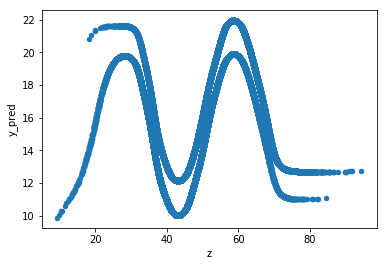

In [ ]:
df['y_pred'] = model.predict(df[['x', 'z']])
df.plot(x='z', y='y_pred', kind='scatter')

So it's kindof ugly, especially at the edges of the support, and a little bumpy throughout. We'd probably do better by fine-tuning the model, but this isn't bad considering how ugly the DGP is!